# Assignment Module 2: Pet Classification

The goal of this assignment is to implement a neural network that classifies images of 37 breeds of cats and dogs from the [Oxford-IIIT-Pet dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/). The assignment is divided into two parts: first, you will be asked to implement from scratch your own neural network for image classification; then, you will fine-tune a pretrained network provided by PyTorch.

## Dataset

The following cells contain the code to download and access the dataset you will be using in this assignment. Note that, although this dataset features each and every image from [Oxford-IIIT-Pet](https://www.robots.ox.ac.uk/~vgg/data/pets/), it uses a different train-val-test split than the original authors.

In [433]:
!git clone https://github.com/CVLAB-Unibo/ipcv-assignment-2.git

fatal: il percorso di destinazione 'ipcv-assignment-2' esiste già e non è una directory vuota.


In [434]:
import warnings
warnings.filterwarnings('ignore')

In [435]:
!pip install wandb
import wandb
wandb.login("945ae0e1b94ae18cfd0af72ed047365e8e8cc7df")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/andreea/.netrc


True

In [436]:
import torch
from torch import nn, Tensor
import numpy as np
import random
from torchvision import models
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import v2 as transforms_v2
from torchvision.transforms import ToTensor
from torchvision.io import decode_image
from torchinfo import summary
from tqdm import tqdm
import torch.optim.lr_scheduler as lr_scheduler
import os
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict, Optional
import time
from PIL import Image
from datetime import datetime
from torchvision.models import resnet18, ResNet18_Weights

In [437]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using {device} device")

Using mps device


In [438]:
def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

Since the dataset is small enough to fit comfortably in memory and the disk I/O represented the biggest bottleneck during training, we choose to trade memory for speed by caching all images in device memory. This trick grants a faster training

In [439]:
class OxfordPetDataset(Dataset):
    def __init__(self, split: str, transform=None) -> None:
        super().__init__()
        self.root = Path("ipcv-assignment-2") / "dataset"
        self.split = split
        self.transform = transform
        self.names, self.labels = self._get_names_and_labels()
        tot_size_bytes = 0
        n_images = 0
        loaded_data = []
        idx = 0
        while idx < len(self.names):
            img_tensor = self.get_img_from_filesystem(idx)
            tot_size_bytes += img_tensor.numel() * img_tensor.element_size()
            n_images += 1
            loaded_data.append(img_tensor)
            idx += 1
        print("tot size", tot_size_bytes, "bytes, for", n_images, "images")
        self.data_tensor = torch.stack(loaded_data).to(device=device)
        self.labels = torch.Tensor(self.labels).type(torch.LongTensor).to(device=device)

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:

        label = self.labels[idx]
        img = self.data_tensor[idx]
        img = self.transform(img).to(device)

        return img, label

    def get_img_from_filesystem(self, idx) -> Tensor:
        img_path = self.root / "images" / f"{self.names[idx]}.jpg"
        img = Image.open(img_path).convert("RGB")
        img = transforms_v2.Resize((256,256))(img)
        img = transforms_v2.ToTensor()(img)
        return img


    def get_num_classes(self) -> int:
        return max(self.labels) + 1

    def _get_names_and_labels(self) -> Tuple[List[str], List[int]]:
        names = []
        labels = []

        with open(self.root / "annotations" / f"{self.split}.txt") as f:
            for line in f:
                if(line[0] == "#"):
                    continue
                name, label = line.replace("\n", "").split(" ")
                names.append(name),
                labels.append(int(label) - 1)

        return names, labels

## Part 1: design your own network

Your goal is to implement a convolutional neural network for image classification and train it from scratch on `OxfordPetDataset`. You should consider yourselves satisfied once you obtain a classification accuracy on the test split of ~60%. You are free to achieve this however you want, except for a few rules you must follow:

- Compile this notebook by displaying the results obtained by the best model you found throughout your experimentation; then show how, by removing some of its components, its performance drops. In other words, do an *ablation study* to prove that your design choices have a positive impact on the final result.

- Do not instantiate an off-the-self PyTorch network. Instead, construct your network as a composition of existing PyTorch layers. In more concrete terms, you can use e.g. `torch.nn.Linear`, but you cannot use e.g. `torchvision.models.alexnet`.

- Show your results and ablations with plots, tables, images, etc. — the clearer, the better.

Don't be too concerned with your model performance: the ~60% is just to give you an idea of when to stop. Keep in mind that a thoroughly justified model with lower accuracy will be rewarded more points than a poorly experimentally validated model with higher accuracy.

In [440]:
# Defining custom Dense Block
class DenseBlock(nn.Module):
    def __init__(self, num_convs:int, growth_rate:int, has_transition:bool = True):
        super(DenseBlock, self).__init__()
        self.num_convs = num_convs
        self.growth_rate = growth_rate
        layer = []
        for i in range(num_convs):
            layer.append(self.conv_block(growth_rate))
        self.dense_net = nn.Sequential(*layer)
        self.transition_net = self.transition_block() if has_transition else None

    def conv_block(self, num_channels):
        return (
            nn.Sequential(
                nn.LazyBatchNorm2d(),
                nn.ReLU(),
                nn.LazyConv2d(num_channels, 3, padding=1))
        )
    
    # Transition block to reduce channel dimensionality (conv has to be 1x1)
    def transition_block(self): 
        compression_factor = 0.5
        num_transition_channels = int(compression_factor * (self.growth_rate * self.num_convs))
        return (
            nn.Sequential(
                nn.LazyBatchNorm2d(),
                nn.ReLU(),
                nn.LazyConv2d(num_transition_channels, 1),
                nn.AvgPool2d(2, stride=2)
                )
        )

    def forward(self, X):
        # In the Dense block, every layer has in input the concatenation of all the previous ones
        for block in self.dense_net:
            last_out = block(X)
            X = torch.cat((X, last_out), dim=1)
        if self.transition_net != None:
            X = self.transition_net(X)
        return X

In [441]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self, num_dense_blocks, num_conv_each_dense, growth_rate, dropout):
        super().__init__()
        stem_block = [ #initial stem block, like resnet
            nn.LazyConv2d(32, 7, stride=2),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2),
        ]

        dense_core = [
            DenseBlock(num_convs=num_conv_each_dense[i], growth_rate=growth_rate, has_transition= True ) for i in range(num_dense_blocks)
        ]

        classification_block = [
            nn.LazyBatchNorm2d(),
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Dropout(dropout),
            nn.LazyLinear(37)
        ]

        self.net_stack = nn.Sequential(*stem_block, *dense_core, *classification_block)

    def forward(self, x):
        result = self.net_stack(x)
        return result

In [442]:
def model_size(model: nn.Module) -> float:
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()

    size_all_mb = (param_size + buffer_size) / 1024**2
    size_all_mb = round(size_all_mb, 2)
    return size_all_mb

In [443]:
def train(dataloader, model, loss_fn, optimizer, scheduler, lr_data):
    model.train()
    total_loss = 0.0
    num_batches = 0

    for X, y in dataloader:
        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        num_batches += 1
        lr_data.append(optimizer.param_groups[0]["lr"])

    avg_loss = total_loss / num_batches
    return avg_loss

In [444]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    accuracy = 100*correct
    return accuracy, test_loss

In [445]:
def evaluate_model(test_loader, model):
    model.eval()
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs, labels
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.append(preds)
            all_labels.append(labels)

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    # --- Accuracy ---
    accuracy = correct / total

    # --- Confusion Matrix ---
    num_classes = outputs.shape[1]
    conf_matrix = torch.zeros(num_classes, num_classes, dtype=torch.int64)
    for t, p in zip(all_labels, all_preds):
        conf_matrix[t, p] += 1

    # --- Precision, Recall, F1 ---
    tp = conf_matrix.diag()
    fp = conf_matrix.sum(dim=0) - tp
    fn = conf_matrix.sum(dim=1) - tp

    precision = tp / (tp + fp + 1e-12)
    recall = tp / (tp + fn + 1e-12)
    f1 = 2 * precision * recall / (precision + recall + 1e-12)

    # Weighted (by class support)
    support = conf_matrix.sum(dim=1)
    weighted_precision = (precision * support).sum() / support.sum()
    weighted_recall = (recall * support).sum() / support.sum()
    weighted_f1 = (f1 * support).sum() / support.sum()

    return {
        "test_accuracy": accuracy,
        "test_precision": weighted_precision.item(),
        "test_recall": weighted_recall.item(),
        "test_f1": weighted_f1.item()
    }

In [446]:
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

## Declaration of data augumentation stacks
training_data_augumentation_stacks = {
    "default" : transforms_v2.Compose([
        transforms_v2.RandomResizedCrop(size=(224, 224)),
        transforms_v2.RandomHorizontalFlip(p=0.5),
        transforms_v2.ColorJitter(
            brightness=0.5,
            contrast=0.5,
            saturation=0.5,
            hue=0.1
        ),
        transforms_v2.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 1.0)),
        transforms_v2.ToDtype(torch.float32, scale=True),
        transforms_v2.Normalize(mean=MEAN,
                    std=STD),
    ]),

    "same_as_default_but_lighter" : transforms_v2.Compose([
        transforms_v2.RandomResizedCrop(size=(224, 224)),
        transforms_v2.RandomHorizontalFlip(p=0.5),
        transforms_v2.ColorJitter(
            brightness=0.1,
            contrast=0.1,
            saturation=0.1,
            hue=0.05
        ),
        transforms_v2.GaussianBlur(kernel_size=(3, 3), sigma=(0.2)),
        transforms_v2.ToDtype(torch.float32, scale=True),
        transforms_v2.Normalize(mean=MEAN,
                    std=STD),
    ])
}

In [ ]:
def run_experiment(parameters):
    print("="*60 + f"\nStart running the model: {parameters.get('experiment_name')}\n" + "="*60)
    # Initialize wandb run
    run = wandb.init(
        project="oxford-pets-classification",  # Change to your project name
        name=parameters.get("experiment_name", "unnamed_experiment"),
        config=parameters,
        reinit=True
    )
    
    BATCH_SIZE = parameters.get("batch_size", 64)
    N_DENS_BLKS = parameters.get("n_dense_blocks", 3)
    N_CONVS_EACH_BLCK = parameters.get("n_conv_each_block", [4,8,7])
    GRWTH_RATE = parameters.get("growth_rate", 12)
    DROPOUT = parameters.get("dropout", 0.1)
    BASE_LR = parameters.get("base_learning_rate", 0.001)
    WARMUP_ITERS = parameters.get("warmup_iter", 7500)
    MAIN_SCH_KICK = parameters.get("main_sched_epochs_kick_in", 60)
    EPOCHS = parameters.get("n_epochs", 100)
    WEIGHT_DECAY = parameters.get("weight_decay", 0.001)
    TRAINING_TRANSFORM_STACK = training_data_augumentation_stacks[parameters.get("transform_stack_name", "default")]
    EXPERIMENT_TYPE = parameters.get("experiment_type", "default")

    # Dataset definition
    validation_transform_stack = transforms_v2.Compose([
        transforms_v2.Resize(256),
        transforms_v2.CenterCrop(224),
        transforms_v2.Normalize(MEAN, STD)
    ])

    train_dataset = OxfordPetDataset(split="train" , transform=TRAINING_TRANSFORM_STACK)
    validation_dataset = OxfordPetDataset(split="val", transform=validation_transform_stack)
    test_dataset = OxfordPetDataset(split="test", transform=validation_transform_stack)

    # Create data loaders
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

    # Create model
    model = NeuralNetwork(num_dense_blocks=N_DENS_BLKS, num_conv_each_dense=N_CONVS_EACH_BLCK, growth_rate=GRWTH_RATE, dropout=DROPOUT).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=BASE_LR, weight_decay=WEIGHT_DECAY)

    warmup_scheduler = lr_scheduler.LinearLR(optimizer, start_factor=0.01, end_factor=1., total_iters=WARMUP_ITERS)
    main_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.01, patience=8)

    batch_lrs = []           # record learning rate per batch
    epoch_end_indices = []   # store index (batch count) at the end of each epoch

    net_performance_data = {
        "train_loss": [],
        "val_loss": [],
        "val_accuracy": []
    }

    t1 = time.time()

    # Add tqdm progress bar
    experiment_name = parameters.get("experiment_name", EXPERIMENT_TYPE)
    pbar = tqdm(range(EPOCHS), desc=f"Training {experiment_name}")

    for t in pbar:
        train_loss = train(train_dataloader, model, loss_fn, optimizer, warmup_scheduler, batch_lrs)
        val_accuracy, val_loss = test(validation_dataloader, model, loss_fn)
        
        if t > MAIN_SCH_KICK: 
            main_scheduler.step(val_accuracy)
            
        net_performance_data["train_loss"].append(train_loss)
        net_performance_data["val_loss"].append(val_loss)
        net_performance_data["val_accuracy"].append(val_accuracy)
        epoch_end_indices.append(len(batch_lrs))
        
        # Update progress bar with metrics
        pbar.set_postfix({
            "Train Loss": f"{train_loss:.4f}",
            "Val Loss": f"{val_loss:.4f}",
            "Val Acc": f"{val_accuracy:.4f}"
        })

        # Watch model on first epoch (after lazy layers are initialized)
        if t == 0:
            model_size_value = model_size(model)
            net_performance_data["model_size_mb"] = model_size_value
            wandb.watch(model, log="all", log_freq=100)
        
        # Log to wandb
        wandb.log({
            "epoch": t,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "val_accuracy": val_accuracy,
            "learning_rate": optimizer.param_groups[0]["lr"]
        })

    t2 = time.time()
    elapsed_time = t2-t1

    print("Done in ", elapsed_time, " sec")
    print("Best accuracy ", np.max(net_performance_data["val_accuracy"]))

    net_performance_data_df = pd.DataFrame(data=net_performance_data)

    # add all experiment parameters to the result dataframe
    for key in parameters:
        if isinstance(parameters[key], list):
            for i, el in enumerate(parameters[key]):
                net_performance_data_df[key + "_"+ str(i)] = el
        else:
            net_performance_data_df[key] = parameters[key]

    # add elapsed time
    net_performance_data_df["elapsed_time_sec"] = elapsed_time

    # create a column for epochs steps indexes
    net_performance_data_df = net_performance_data_df.reset_index().rename(columns={"index":"epoch"})

    # add final evaluation stats
    eval_performaces = evaluate_model(test_dataloader, model)
    for metric in eval_performaces:
        net_performance_data_df[metric] = eval_performaces[metric]
    
    # Log final metrics to wandb
    wandb.log({
        "test_accuracy": eval_performaces["test_accuracy"],
        "test_precision": eval_performaces["test_precision"],
        "test_recall": eval_performaces["test_recall"],
        "test_f1": eval_performaces["test_f1"],
        "total_training_time": elapsed_time
    })
    
    # Save the CSV as an artifact
    artifact = wandb.Artifact(
        name=f"results_{parameters.get('experiment_name', 'unnamed')}", 
        type="results"
    )
    csv_path = f"./temp_{parameters.get('experiment_name', 'unnamed')}.csv"
    net_performance_data_df.to_csv(csv_path, index=False)
    artifact.add_file(csv_path)
    wandb.log_artifact(artifact)
    wandb.finish()
    
    """ # Clean up GPU memory
    del model, train_dataset, validation_dataset, test_dataset
    del train_dataloader, validation_dataloader, test_dataloader
    torch.cuda.empty_cache() """

    return net_performance_data_df

### Ablation study

In [448]:
parameters_base = [
    # Baseline
    {
        "experiment_name": "24_grwth_rate_baseline",
        "batch_size" : 64,
        "n_dense_blocks": 3,
        "n_conv_each_block": [6,16,14],
        "growth_rate": 24,
        "dropout": 0.2,
        "base_learning_rate": 0.001,
        "warmup_iter": 7500,
        "main_sched_epochs_kick_in": 70,
        "n_epochs": 180,
        "weight_decay": 0.001,
        "transform_stack_name": "default"
    },

    # Experiments on regularization
    {
        "experiment_name": "high_dropout",
        "batch_size" : 64,
        "n_dense_blocks": 3,
        "n_conv_each_block": [6,16,14],
        "growth_rate": 24,
        "dropout": 0.4,
        "base_learning_rate": 0.001,
        "warmup_iter": 7500,
        "main_sched_epochs_kick_in": 70,
        "n_epochs": 180,
        "weight_decay": 0.001,
        "transform_stack_name": "default"
    },
    {
        "experiment_name": "weight_decay_heavy",
        "batch_size": 64,
        "n_dense_blocks": 3,
        "n_conv_each_block": [6,16,14],
        "growth_rate": 24,
        "dropout": 0.2,
        "base_learning_rate": 0.001,
        "warmup_iter": 7500,
        "main_sched_epochs_kick_in": 70,
        "n_epochs": 180,
        "weight_decay": 0.007,
        "transform_stack_name": "default"
    },
    {
        "experiment_name": "near_zero_weight_decay",
        "batch_size": 64,
        "n_dense_blocks": 3,
        "n_conv_each_block": [6,16,14],
        "growth_rate": 24,
        "dropout": 0.2,
        "base_learning_rate": 0.001,
        "warmup_iter": 7500,
        "main_sched_epochs_kick_in": 70,
        "n_epochs": 180,
        "weight_decay": 0.00005,
        "transform_stack_name": "default"
    },
    {
        "experiment_name": "light_data_aug",
        "batch_size": 64,
        "n_dense_blocks": 3,
        "n_conv_each_block": [6,16,14],
        "growth_rate": 24,
        "dropout": 0.2,
        "base_learning_rate": 0.001,
        "warmup_iter": 7500,
        "main_sched_epochs_kick_in": 70,
        "n_epochs": 180,
        "weight_decay": 0.001,
        "transform_stack_name": "same_as_default_but_lighter"
    },

    # Experiments on model size
    {
        "experiment_name": "capacity_increase_blocks_growth",
        "batch_size": 64,
        "n_dense_blocks": 4,
        "n_conv_each_block": [6, 12, 16, 14],
        "growth_rate": 32,
        "dropout": 0.2,
        "base_learning_rate": 0.001,
        "warmup_iter": 7500,
        "main_sched_epochs_kick_in": 70,
        "n_epochs": 180,
        "weight_decay": 0.001,
        "transform_stack_name": "default"
    },
    {
        "experiment_name": "lightweight_model_ablation",
        "batch_size": 64,
        "n_dense_blocks": 3,
        "n_conv_each_block": [4, 10, 10],
        "growth_rate": 16,
        "dropout": 0.2,
        "base_learning_rate": 0.001,
        "warmup_iter": 5000,
        "main_sched_epochs_kick_in": 60,
        "n_epochs": 180,
        "weight_decay": 0.0005,
        "transform_stack_name": "default"
    },
    {
        "experiment_name": "deep_dense_blocks",
        "batch_size": 32,
        "n_dense_blocks": 3,
        "n_conv_each_block": [12, 24, 24],
        "growth_rate": 24,
        "dropout": 0.2,
        "base_learning_rate": 0.0008,
        "warmup_iter": 10000,
        "main_sched_epochs_kick_in": 90,
        "n_epochs": 180,
        "weight_decay": 0.0015,
        "transform_stack_name": "default"
    },
    
    # Experiments on training parameters
    {
        "experiment_name": "large_warmup",
        "batch_size": 64,
        "n_dense_blocks": 3,
        "n_conv_each_block": [6,16,14],
        "growth_rate": 24,
        "dropout": 0.2,
        "base_learning_rate": 0.0005,
        "warmup_iter": 20000,
        "main_sched_epochs_kick_in": 90,
        "n_epochs": 180,
        "weight_decay": 0.001,
        "transform_stack_name": "default"
    },
    {
        "experiment_name": "batch32_lr_double",
        "batch_size": 32,
        "n_dense_blocks": 3,
        "n_conv_each_block": [6,16,14],
        "growth_rate": 24,
        "dropout": 0.2,
        "base_learning_rate": 0.002,
        "warmup_iter": 7500,
        "main_sched_epochs_kick_in": 70,
        "n_epochs": 180,
        "weight_decay": 0.001,
        "transform_stack_name": "default"
    },
    {
        "experiment_name": "big_128batch",
        "batch_size": 128,
        "n_dense_blocks": 3,
        "n_conv_each_block": [6,16,14],
        "growth_rate": 24,
        "dropout": 0.2,
        "base_learning_rate": 0.001,
        "warmup_iter": 7500,
        "main_sched_epochs_kick_in": 70,
        "n_epochs": 180,
        "weight_decay": 0.001,
        "transform_stack_name": "default"
    }
]

In [450]:
total_results = []
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

### Actual run of the experiments
if not Path("./results.csv").exists():
    for par in parameters_base:
        total_results.append(run_experiment(par))
        # update partial results after each experiment
        df_combined = pd.concat(total_results, ignore_index=True)
        df_combined.to_csv(f"./results.csv")

In [ ]:
custom_net_df = pd.read_csv("./results.csv")
sns.set_theme(style="whitegrid", context="talk")

# ================================================================
# 1. TRAIN/VAL LOSS CURVES BY EXPERIMENT
# ================================================================
def plot_loss_curves(df):
    experiment_names = df["experiment_name"].unique()
    n_experiments = len(experiment_names)
    
    # Calculate grid dimensions (roughly square)
    n_cols = int(np.ceil(np.sqrt(n_experiments)))
    n_rows = int(np.ceil(n_experiments / n_cols))
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 4*n_rows))
    
    # Flatten axes array for easy iteration
    if n_experiments == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    for idx, name in enumerate(experiment_names):
        sub = df[df["experiment_name"] == name]
        ax = axes[idx]
        
        ax.plot(sub["epoch"], sub["train_loss"], alpha=0.7, label="Train Loss", color='indigo')
        ax.plot(sub["epoch"], sub["val_loss"], alpha=0.7, linestyle="--", label="Val Loss", color='darksalmon')
        
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        ax.set_title(f"{name}", fontsize=10, wrap=True)
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # Hide unused subplots
    for idx in range(n_experiments, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

# ================================================================
# 2. BEST TEST ACCURACY PER EXPERIMENT — BARPLOT
# ================================================================
def plot_test_accuracy(df):
    df_best = df.groupby("experiment_name").agg({"test_accuracy": "max"}).reset_index()
    df_best = df_best.sort_values("test_accuracy", ascending=False)

    plt.figure(figsize=(12,6))
    sns.barplot(data=df_best, x="test_accuracy", y="experiment_name", palette="magma")
    plt.xlabel("Test Accuracy")
    plt.ylabel("Experiment")
    plt.title("Test Accuracy by Experiment")
    plt.tight_layout()
    plt.show()

# ================================================================
# 3. EFFECT OF SINGLE HYPERPARAMETERS ON TEST ACCURACY
# ================================================================
def plot_hyperparam_performance(df, hyperparam):
    plt.figure(figsize=(8, 5))
    
    # Group by hyperparameter value and calculate mean + std
    grouped = df.groupby(hyperparam)['test_accuracy'].agg(['mean', 'std', 'count']).reset_index()
    
    # Create bar plot with error bars
    plt.bar(grouped[hyperparam].astype(str), grouped['mean'], 
            yerr=grouped['std'], capsize=5, alpha=0.7, edgecolor='black', color='darksalmon')
    
    # Add value labels on top of bars
    for i, row in grouped.iterrows():
        plt.text(i, row['mean'] + row['std'] + 0.001, 
                f"{row['mean']:.3f}", ha='center', fontweight='bold')
    
    plt.xlabel(hyperparam, fontsize=12)
    plt.ylabel('Test Accuracy', fontsize=12)
    plt.title(f'Effect of {hyperparam} on Test Accuracy', fontsize=14)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

# ================================================================
# 4. REGULARIZATION TECHNIQUES COMPARISON
# ================================================================
def compare_regularization(df):
    plt.figure(figsize=(12, 6))
    
    reg_experiments = {
        "24_grwth_rate_baseline": "Baseline",
        "high_dropout": "High Dropout", 
        "weight_decay_heavy": "Heavy Weight Decay",
        "near_zero_weight_decay": "Minimal Weight Decay",
        "light_data_aug": "Light Data Augmentation"
    }
    
    df_reg = df[df['experiment_name'].isin(reg_experiments.keys())]
    
    for name, label in reg_experiments.items():
        sub = df_reg[df_reg['experiment_name'] == name]
        # Just take the mean across all runs per epoch
        grouped = sub.groupby('epoch')['val_accuracy'].mean()
        plt.plot(grouped.index, grouped.values, label=label, linewidth=3, alpha=0.8)
    
    plt.xlabel('Epoch', fontsize=13, fontweight='bold')
    plt.ylabel('Validation Accuracy (%)', fontsize=13, fontweight='bold')
    plt.title('Regularization Strategy Comparison', fontsize=15, fontweight='bold')
    plt.legend(fontsize=11, loc='lower right', framealpha=0.95)
    plt.grid(alpha=0.3, linestyle='--')
    plt.xlim(0, 180)
    plt.ylim(0, 75)
    plt.tight_layout()
    plt.show()
    
# ================================================================
# 5. CORRELATION HEATMAP (Hyperparams vs. Results)
# ================================================================
def plot_correlation_heatmap(df):
    # Keep numeric columns only
    num_df = df.select_dtypes(include=["float64", "int64"]).drop(columns=["epoch"])
    corr = num_df.corr()

    plt.figure(figsize=(14,10))
    sns.heatmap(corr, cmap="coolwarm", center=0, annot=False)
    plt.title("Correlation Heatmap of Hyperparameters and Outcomes")
    plt.show()

# ================================================================
# 6. ABLATION: E.g., "Dropout vs Epoch Curve"
# ================================================================
def compare_by_feature(df, feature, metric="val_accuracy"):
    plt.figure(figsize=(10, 5))
    
    for value, sub in df.groupby(feature):
        # Aggregate across multiple runs if present
        grouped = sub.groupby("epoch")[metric].agg(['mean', 'std']).reset_index()
        
        # Plot mean with confidence band
        plt.plot(grouped["epoch"], grouped["mean"], label=f"{feature}={value}", linewidth=2)
        plt.fill_between(grouped["epoch"], 
                        grouped["mean"] - grouped["std"],
                        grouped["mean"] + grouped["std"],
                        alpha=0.2)
    
    plt.title(f"{metric} curves grouped by {feature}", fontsize=14, fontweight='bold')
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel(metric, fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# ================================================================
# 7. TEST ACCURACY vs TRAINING TIME (Efficiency Frontier)
# ================================================================
def plot_efficiency(df):
    summary = df.groupby("experiment_name").agg({
        "elapsed_time_sec": "max",
        "test_accuracy": "max",
    }).reset_index()

    plt.figure(figsize=(10,6))
    sns.scatterplot(
        data=summary,
        x="elapsed_time_sec", y="test_accuracy", hue="test_accuracy",
        palette="viridis", s=150
    )
    plt.xlabel("Training Time (sec)")
    plt.ylabel("Test Accuracy")
    plt.title("Accuracy vs Training Efficiency (Pareto-like View)")
    plt.tight_layout()
    plt.show()

# ================================================================
# 8. TEST ACCURACY VS MODEL SIZE (MB trainable parameters)
# ================================================================
def plot_size_vs_accuracy(df):
    summary = df.groupby("experiment_name").agg({
        "model_size_mb": "max",
        "test_accuracy": "max",
    }).reset_index()

    plt.figure(figsize=(10,6))
    sns.scatterplot(
        data=summary,
        x="model_size_mb", y="test_accuracy", hue="test_accuracy",
        palette="viridis", s=150
    )
    plt.xlabel("Model Size (MB)")
    plt.ylabel("Test Accuracy")
    plt.title("Model Size vs Test Accuracy")
    plt.tight_layout()
    plt.show()

# ================================================================
# 9. MULTI-PARAMETER GRID PLOT (e.g., dropout × growth_rate)
# ================================================================
def grid_compare(df, x="dropout", y="growth_rate", metric="test_accuracy"):
    summary = df.groupby("experiment_name").mean(numeric_only=True)
    summary = summary.reset_index()

    pivot = summary.pivot_table(values=metric, index=y, columns=x)

    plt.figure(figsize=(8,5))
    sns.heatmap(pivot, annot=True, cmap="flare")
    plt.title(f"{metric} across {x} × {y} ablation grid")
    plt.ylabel(y)
    plt.xlabel(x)
    plt.show()

# ================================================================
# EXTRA: TRAINING TIME COMPARISON ACROSS EXPERIMENTS
# ================================================================
def plot_training_time(df):
    summary = df.groupby("experiment_name")["elapsed_time_sec"].max(numeric_only=True).reset_index()
    summary = summary.sort_values("elapsed_time_sec")

    plt.figure(figsize=(12,6))
    sns.barplot(
        data=summary,
        x="elapsed_time_sec",
        y="experiment_name",
        palette="magma"
    )
    plt.xlabel("Total Training Time (sec)")
    plt.ylabel("Experiment")
    plt.title("Training Time Comparison Across Experiments")
    plt.tight_layout()
    plt.show()

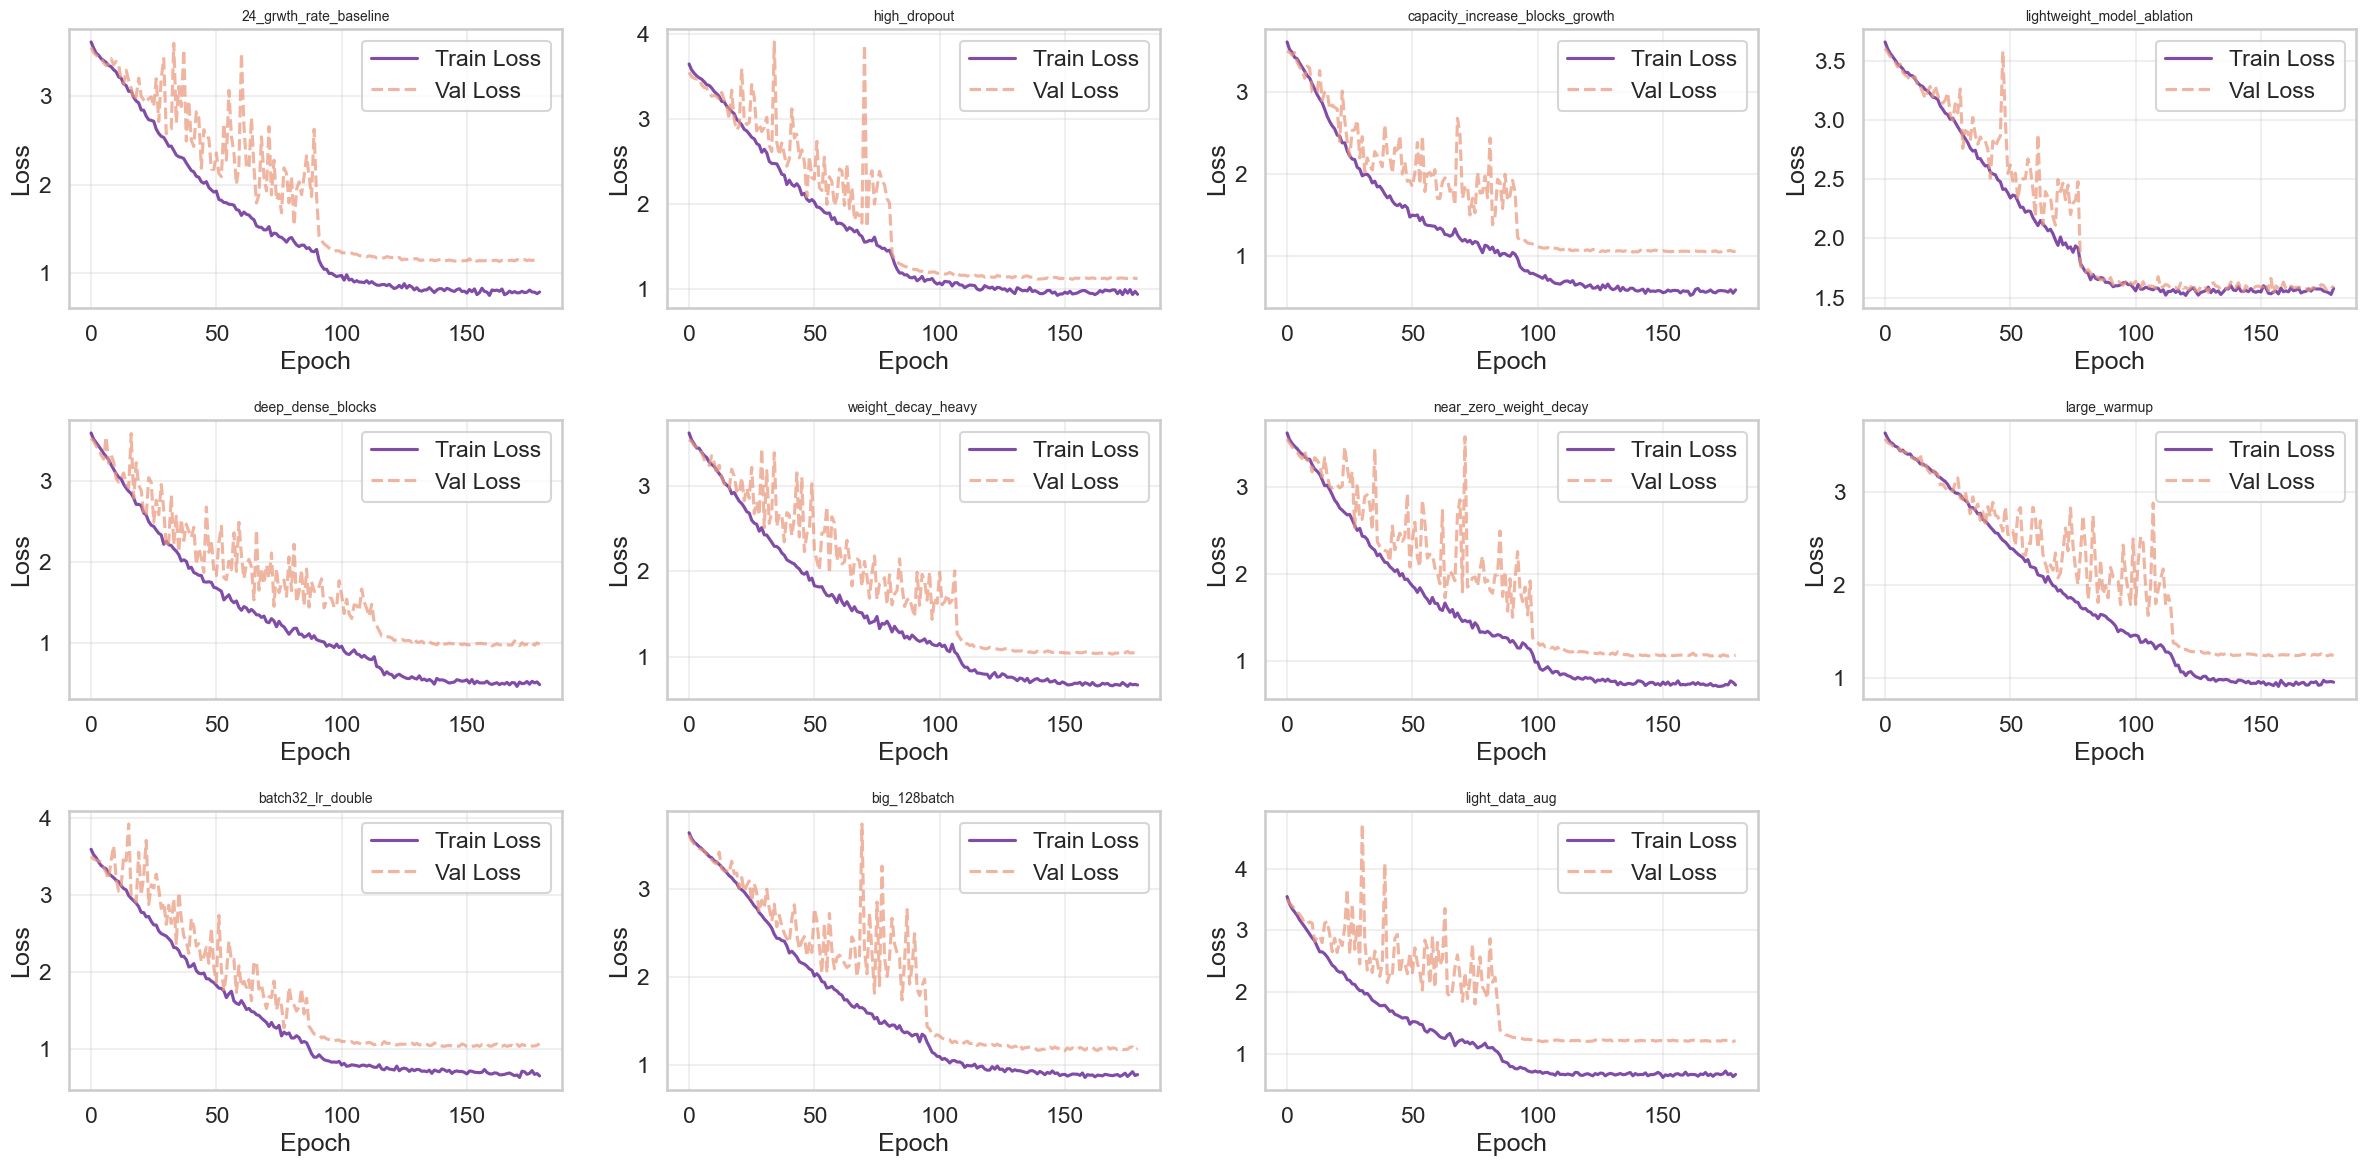

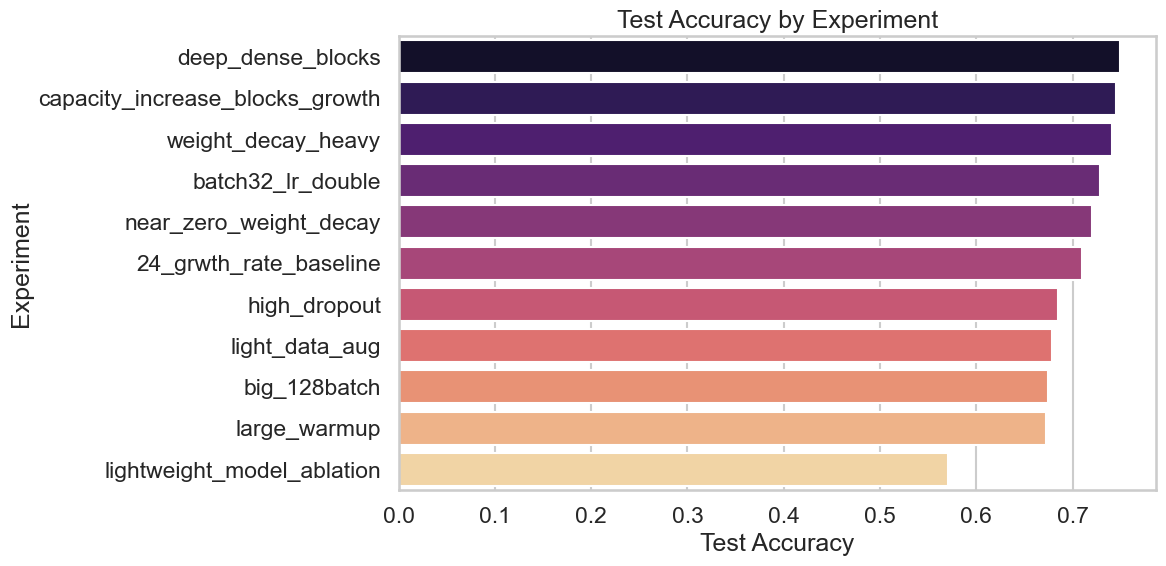

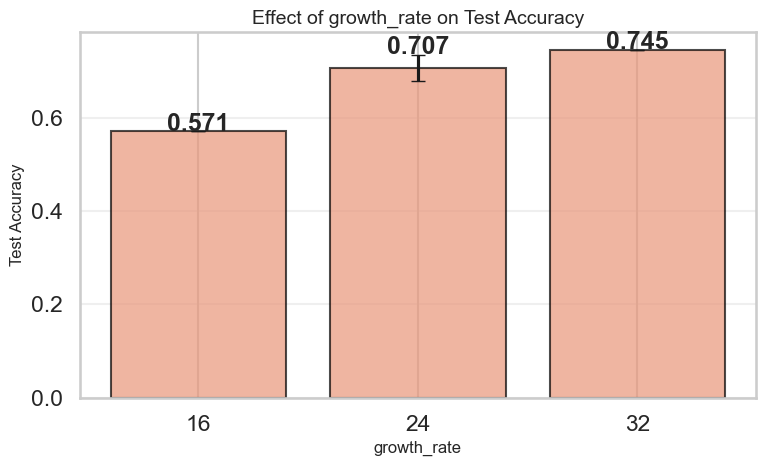

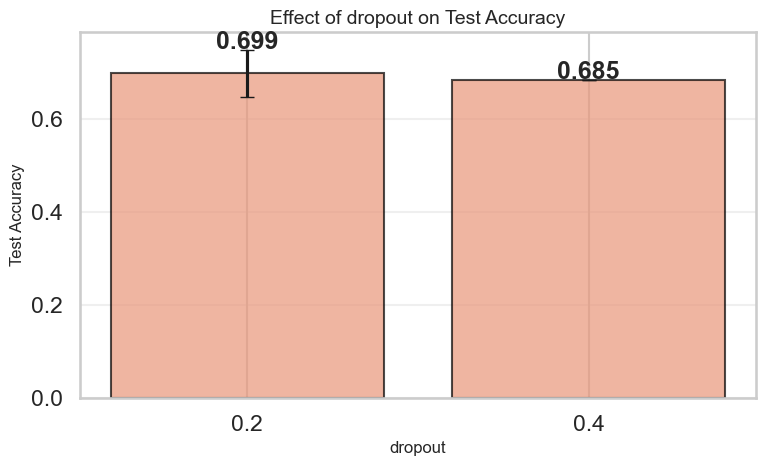

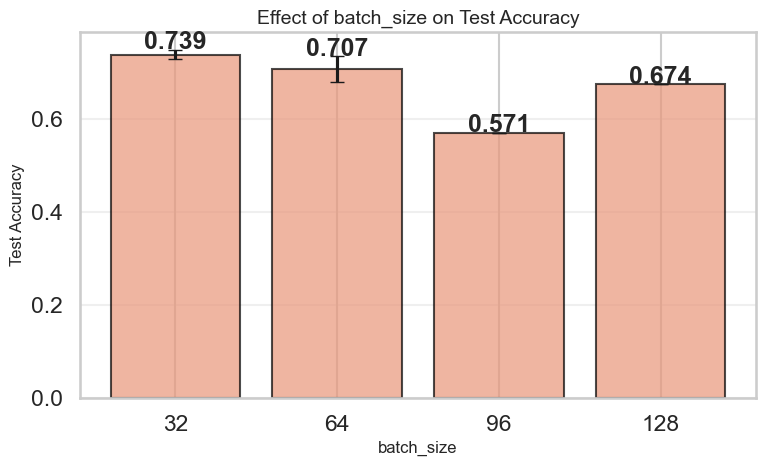

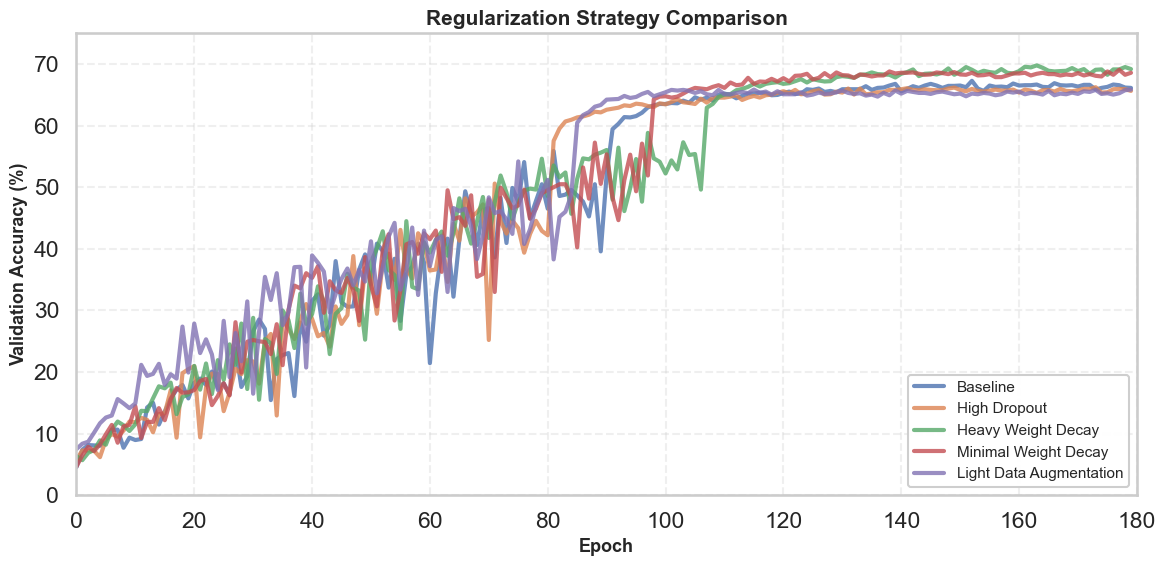

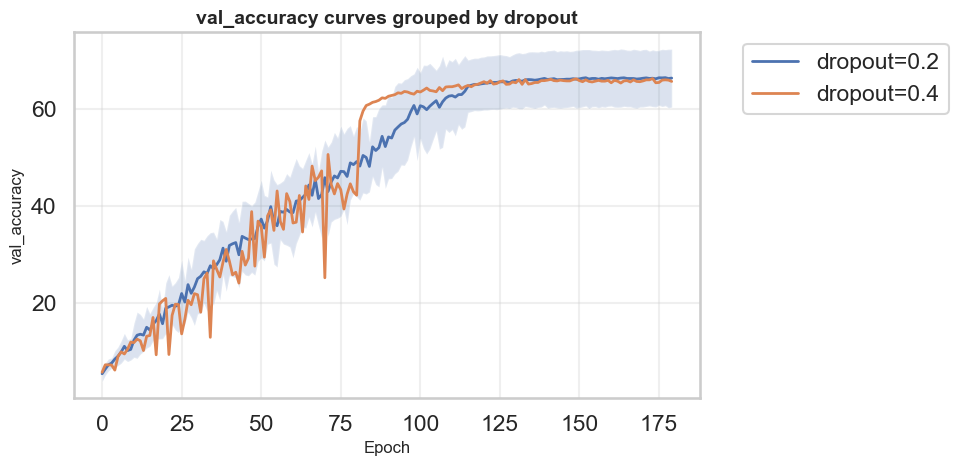

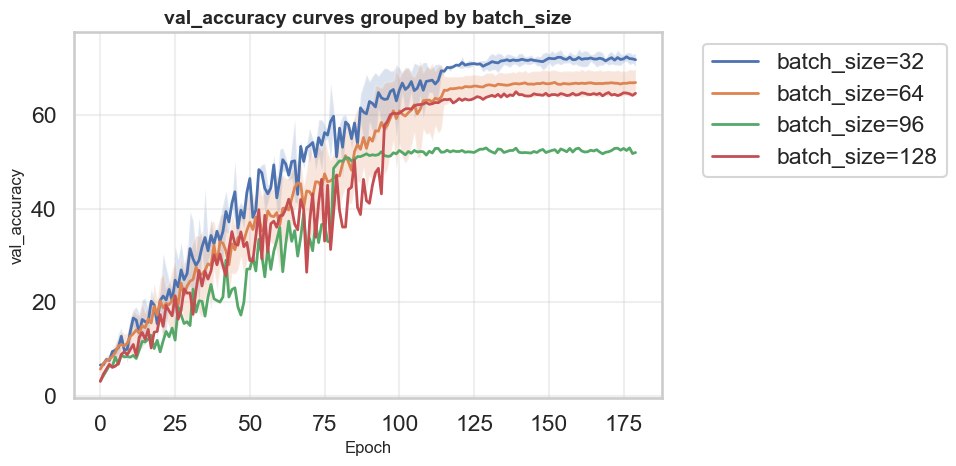

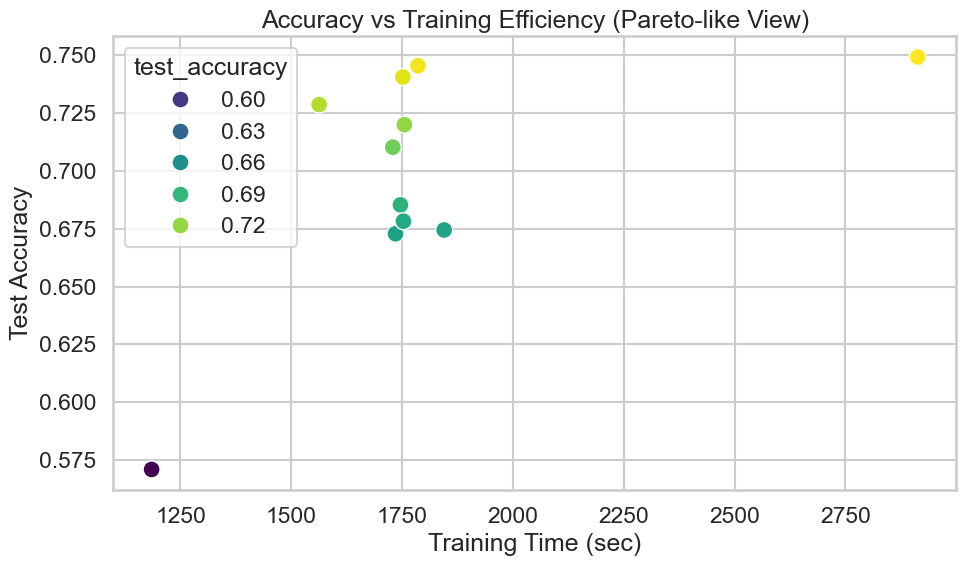

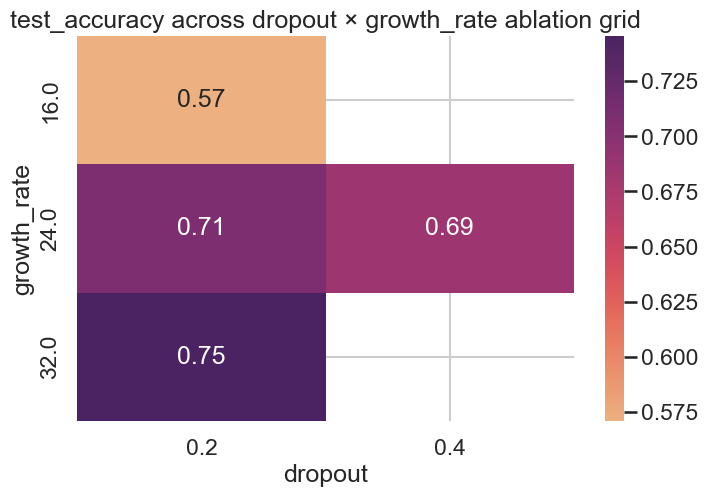

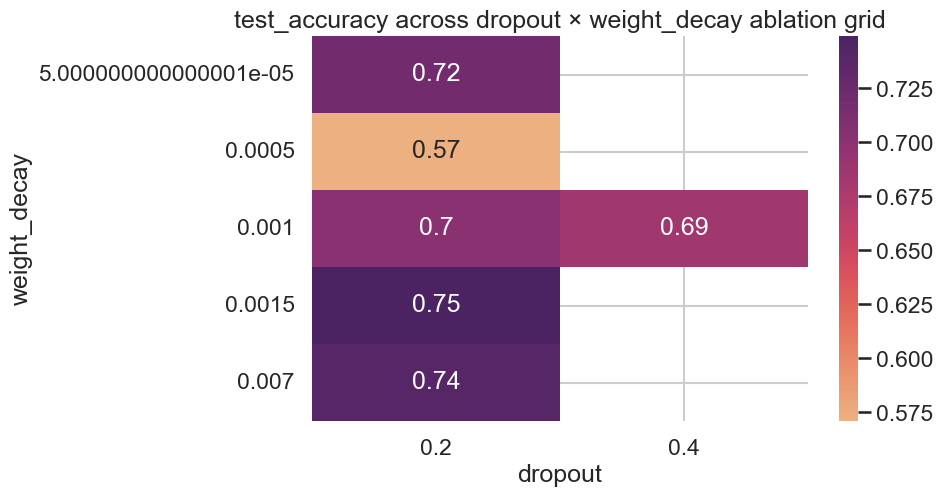

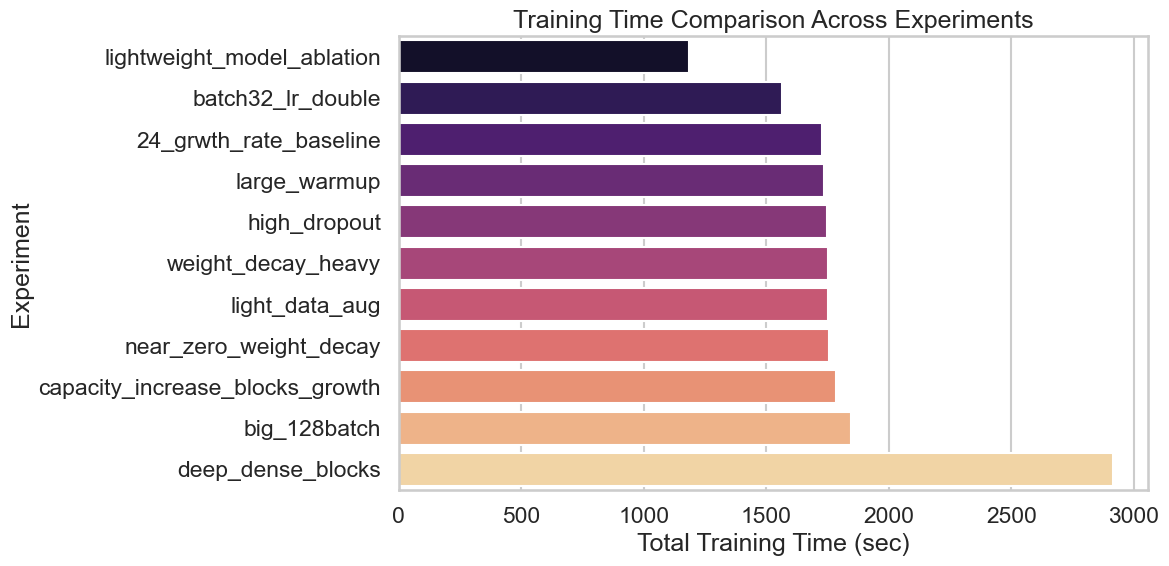

In [ ]:
plot_loss_curves(custom_net_df)
plot_test_accuracy(custom_net_df)
plot_hyperparam_performance(custom_net_df, "growth_rate")
plot_hyperparam_performance(custom_net_df, "dropout")
plot_hyperparam_performance(custom_net_df, "batch_size")
compare_regularization(custom_net_df)
# plot_correlation_heatmap(custom_net_df)
compare_by_feature(custom_net_df, "dropout")
compare_by_feature(custom_net_df, "batch_size")
plot_efficiency(custom_net_df)
plot_size_vs_accuracy(custom_net_df)
grid_compare(custom_net_df, x="dropout", y="growth_rate")
grid_compare(custom_net_df, x="dropout", y="weight_decay")
plot_training_time(custom_net_df)


## Part 2: fine-tune an existing network

Your goal is to fine-tune a pretrained ResNet-18 model on `OxfordPetDataset`. Use the implementation provided by PyTorch, i.e. the opposite of part 1. Specifically, use the PyTorch ResNet-18 model pretrained on ImageNet-1K (V1). Divide your fine-tuning into two parts:

### 2A.
 First, fine-tune the ResNet-18 with the same training hyperparameters you used for your best model in part 1.


In [453]:
def get_model_resnet18():
    # Define the model and local path for saving weights
    model_resnet_18 = models.resnet18()
    weights_path = "./resnet18_weights.pth"

    # Check if the file exists locally
    if os.path.exists(weights_path):
        print("✅ Loading existing ResNet-18 weights...")
        state_dict = torch.load(weights_path, map_location="cpu")
        model_resnet_18.load_state_dict(state_dict)
    else:
        print("⬇️  Downloading ResNet-18 weights...")
        model_resnet_18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)  # Downloads pretrained weights
        torch.save(model_resnet_18.state_dict(), weights_path)
        print("💾 Weights saved locally at:", weights_path)
    return model_resnet_18

### 2B.
Then, tweak the training hyperparameters in order to increase the accuracy on the test split. Justify your choices by analyzing the training plots and/or citing sources that guided you in your decisions — papers, blog posts, YouTube videos, or whatever else you may find useful. You should consider yourselves satisfied once you obtain a classification accuracy on the test split of ~90%.

In [454]:
parameters_finetune_base = [
{
    "experiment_name": "same_as_densenet",
    "batch_size": 64,
    "dropout": 0.2,
    "base_learning_rate": 0.001,
    "warmup_iter": 1500,
    "main_sched_epochs_kick_in": 30,
    "n_epochs": 90,
    "weight_decay": 0.001,
    "transform_stack_name": "default",
    "experiment_type": "resnet18"
},
{
    "experiment_name": "better_model",
    "batch_size": 64,
    "dropout": 0.2,
    "base_learning_rate": 0.0001,
    "warmup_iter": 1500,
    "main_sched_epochs_kick_in": 30,
    "n_epochs": 90,
    "weight_decay": 0.001,
    "transform_stack_name": "trivial_augument_wide",
    "experiment_type": "resnet18"
},
{
    "experiment_name": "better_model_smaller_batches",
    "batch_size": 32,
    "dropout": 0.2,
    "base_learning_rate": 0.0001,
    "warmup_iter": 1500,
    "main_sched_epochs_kick_in": 30,
    "n_epochs": 90,
    "weight_decay": 0.001,
    "transform_stack_name": "trivial_augument_wide",
    "experiment_type": "resnet18"
},
{
    "experiment_name": "better_model_larger_batches",
    "batch_size": 128,
    "dropout": 0.2,
    "base_learning_rate": 0.0001,
    "warmup_iter": 1500,
    "main_sched_epochs_kick_in": 30,
    "n_epochs": 90,
    "weight_decay": 0.001,
    "transform_stack_name": "trivial_augument_wide",
    "experiment_type": "resnet18"
},
{
    "experiment_name": "better_model_high_dropout",
    "batch_size": 64,
    "dropout": 0.4,
    "base_learning_rate": 0.0001,
    "warmup_iter": 1500,
    "main_sched_epochs_kick_in": 30,
    "n_epochs": 90,
    "weight_decay": 0.001,
    "transform_stack_name": "trivial_augument_wide",
    "experiment_type": "resnet18"
},
]

In [455]:
total_results = []

### Actual run of the experiments
if not Path("./results_finetune.csv").exists():
    for par in parameters_finetune_base:
        total_results.append(run_experiment(par))
        # update partial results after each experiment
        df_combined = pd.concat(total_results, ignore_index=True)
        df_combined.to_csv(f"./results_finetune.csv")

<Axes: xlabel='epoch'>

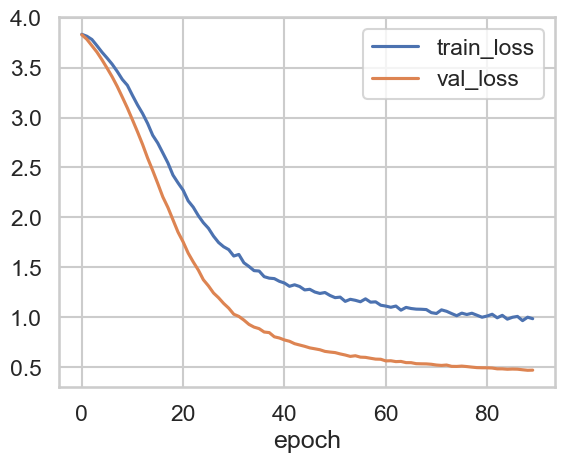

In [456]:
finetune_df = pd.read_csv("./results_finetune.csv")

row_best_accuracy = finetune_df[finetune_df["test_accuracy"] == np.max(finetune_df["test_accuracy"])]
best_experiment_name = row_best_accuracy["experiment_name"].iloc[0]
best_experiment = finetune_df[finetune_df["experiment_name"] == best_experiment_name]
loss = best_experiment[["epoch","train_loss", "val_loss"]].copy()
loss = loss.set_index("epoch")
loss.plot()

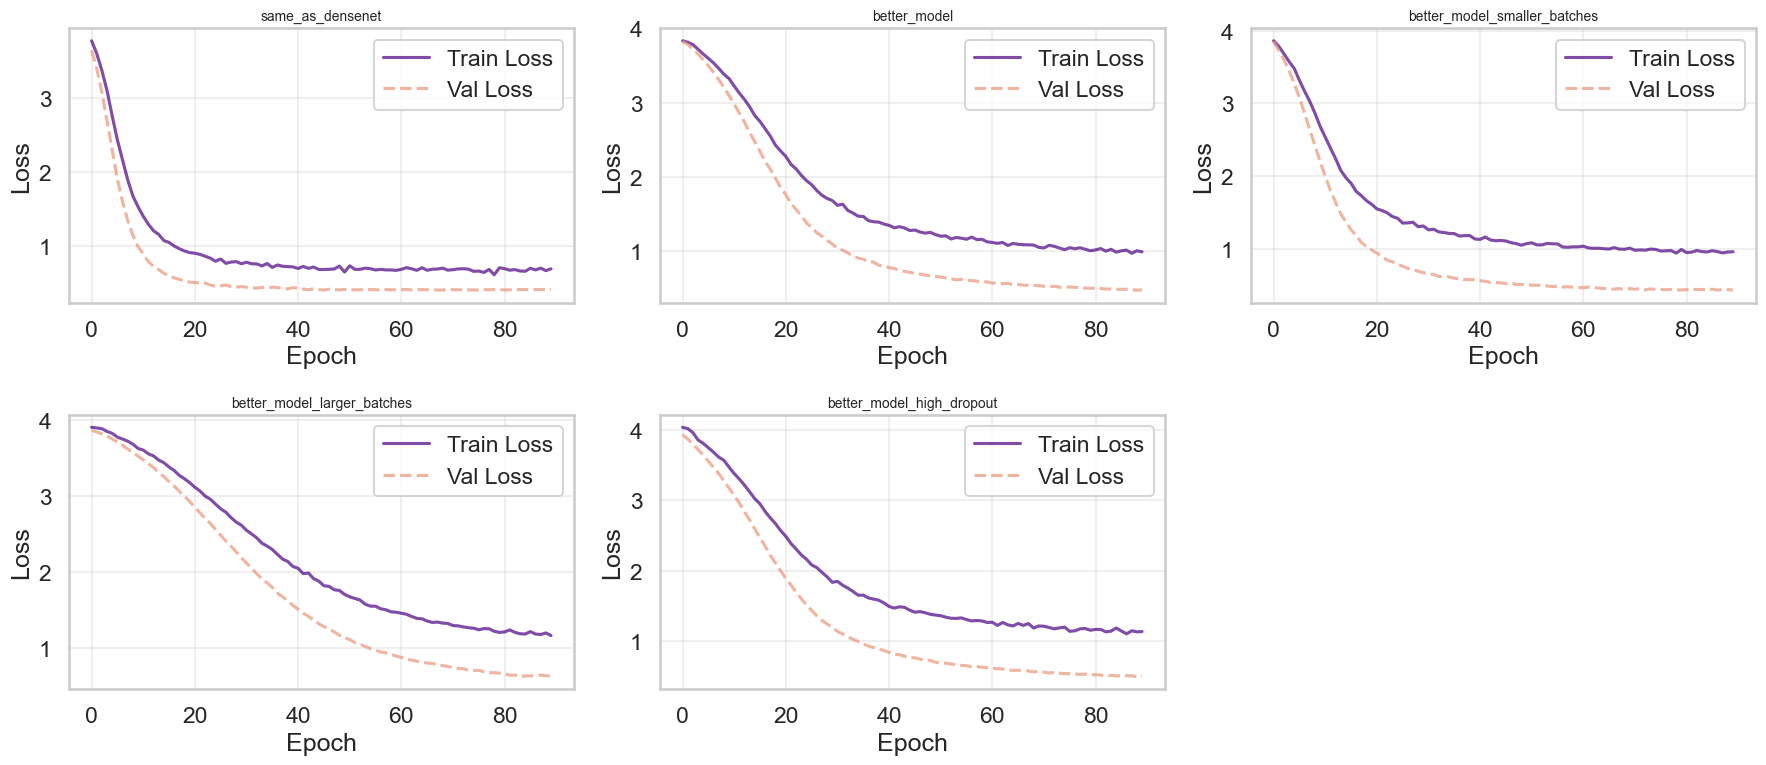

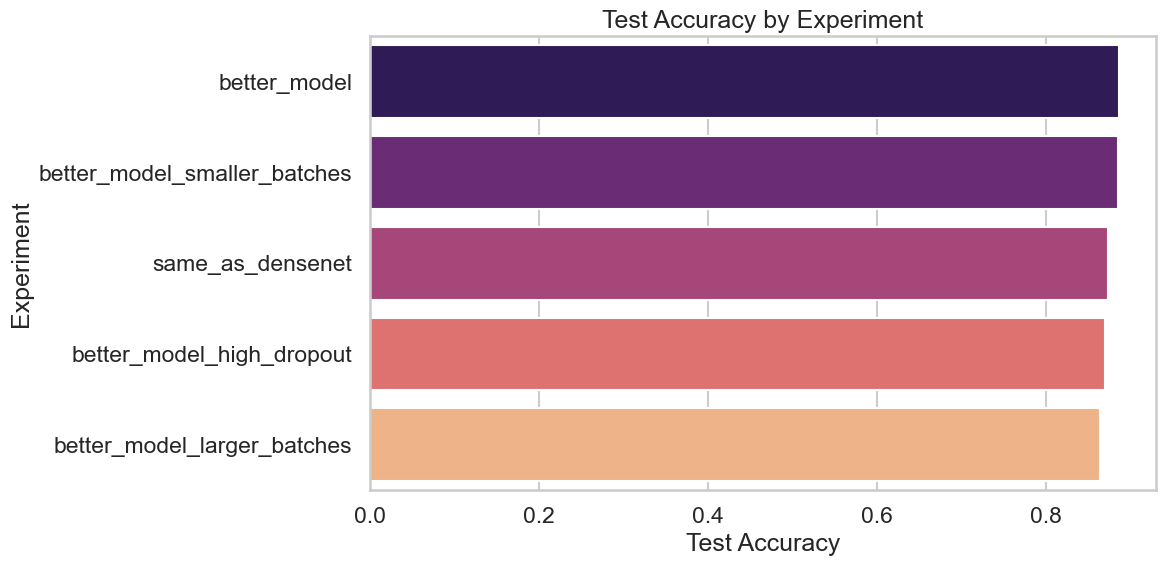

In [457]:
plot_loss_curves(finetune_df)
plot_test_accuracy(finetune_df)

In [458]:
all_experiment_names = finetune_df["experiment_name"].unique()
for name in all_experiment_names:
    print("name: ", name, "\ttest_accuracy:", np.max(finetune_df[finetune_df["experiment_name"] == name]["test_accuracy"]), "\ttime:", finetune_df[finetune_df["experiment_name"] == name]["elapsed_time_sec"].iloc[0])


name:  same_as_densenet 	test_accuracy: 0.8743228602383532 	time: 528.2385866641998
name:  better_model 	test_accuracy: 0.886240520043337 	time: 242.17839789390564
name:  better_model_smaller_batches 	test_accuracy: 0.8856988082340195 	time: 243.4578342437744
name:  better_model_larger_batches 	test_accuracy: 0.8645720476706392 	time: 252.70855903625488
name:  better_model_high_dropout 	test_accuracy: 0.8705308775731311 	time: 243.5706083774567
